# Project Description

This project implements a **supervised machine learning pipeline** to classify events recorded by the MAGIC Gamma Telescope into two categories:

- $y = 1$: gamma-ray event (signal)  
- $y = 0$: hadron event (background)

The dataset consists of $m$ observations $X = [x_1, x_2, ..., x_m]^T$, where each observation $x_i \in \mathbb{R}^n$ is represented by $n$ features derived from telescope measurements. The corresponding labels are $Y = [y_1, y_2, ..., y_m]^T$, with $y_i \in \{0,1\}$.

## Objective

Formally, the task is to learn a mapping:

$$
f: \mathbb{R}^n \rightarrow \{0,1\}, \quad f(x_i) \approx y_i
$$

by minimizing an appropriate loss function $\mathcal{L}$ over the training data.

For example, for probabilistic classifiers, we minimize the **binary cross-entropy**:

$$
\mathcal{L} = - \frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right], \quad \hat{y}_i = P(y_i=1 \mid x_i)
$$

The pipeline evaluates multiple models $\mathcal{M} = \{ \text{Logistic Regression}, \text{Naive Bayes}, \text{KNN}, \text{SVM}, \text{Decision Tree}, \text{Random Forest}, \text{Gradient Boosting}, \text{Neural Network} \}$, each parameterized by a set of hyperparameters $\theta$:

$$
f_\theta^{(k)}(x_i) \approx y_i, \quad k = 1,2,...,|\mathcal{M}|
$$

The performance of each model is quantified using the following metrics:

1. **Accuracy**:  
$$
\text{Accuracy} = \frac{1}{m} \sum_{i=1}^{m} \mathbf{1} \big( \hat{y}_i = y_i \big)
$$

2. **Precision, Recall, and F1-score** for each class $c \in \{0,1\}$:

$$
\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}, \quad
\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}, \quad
F1_c = 2 \cdot \frac{\text{Precision}_c \cdot \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
$$

3. **ROC-AUC**: Area under the **Receiver Operating Characteristic (ROC) curve**, where

$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}, \quad \text{ROC-AUC} = \int_0^1 \text{TPR(FPR)} \, d(\text{FPR})
$$

The ultimate goal is to **identify the optimal model** $f_{\theta^*}^{(k^*)}$ and hyperparameters $\theta^*$ that maximize predictive performance on unseen data while minimizing overfitting.


###Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Donated by:
P. Savicky
Institute of Computer Science, AS of CR
Czech Republic
savicky '@' cs.cas.cz

Dataset link: https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

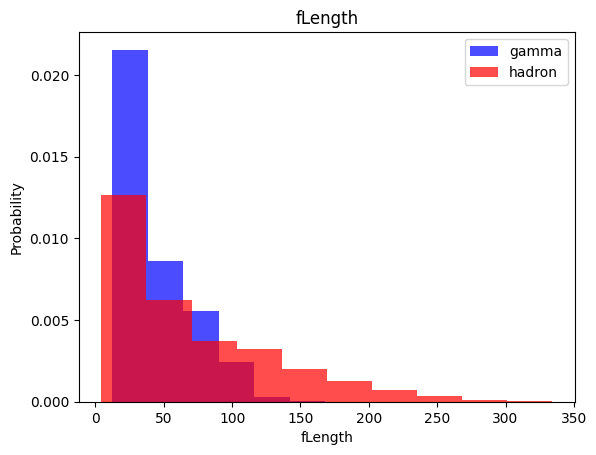

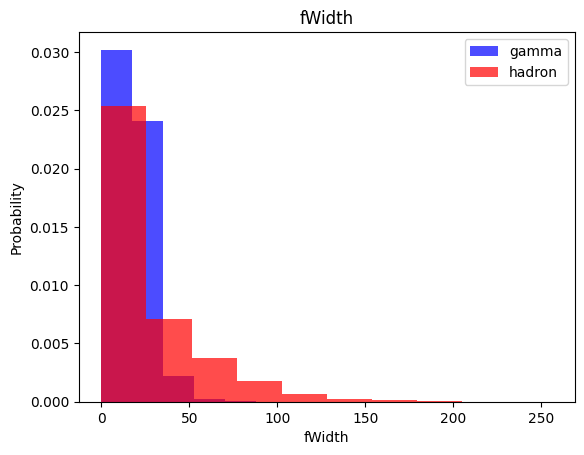

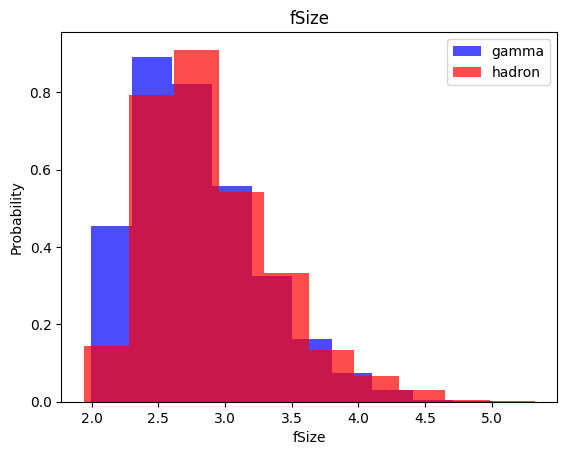

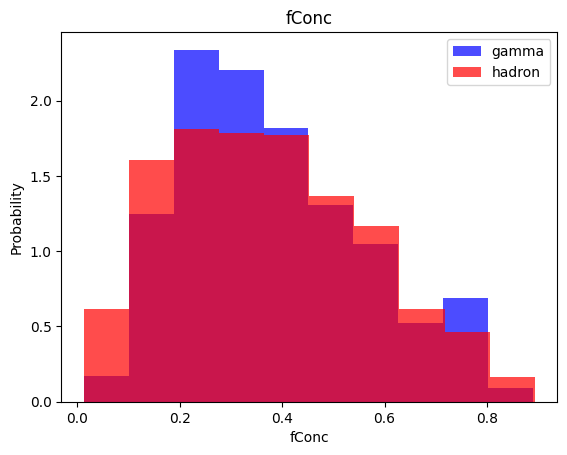

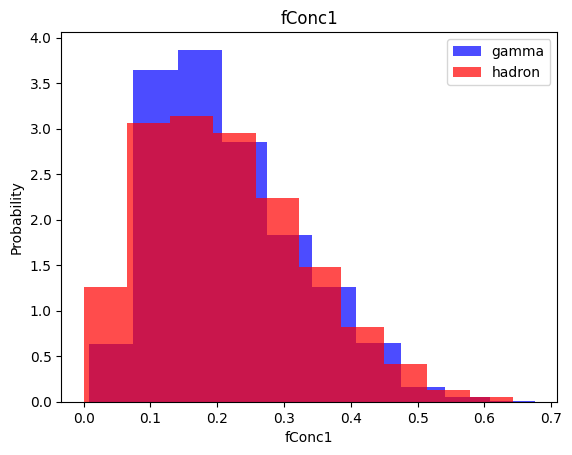

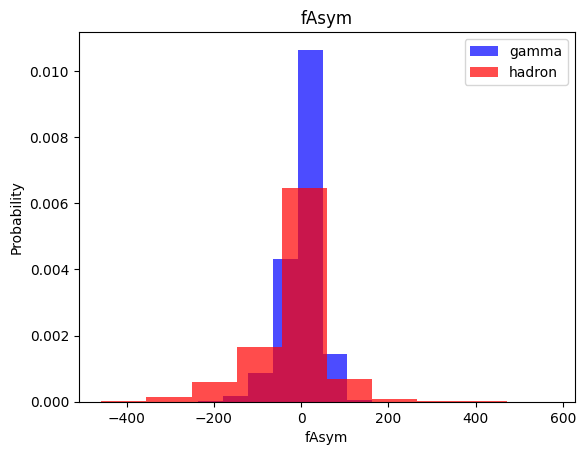

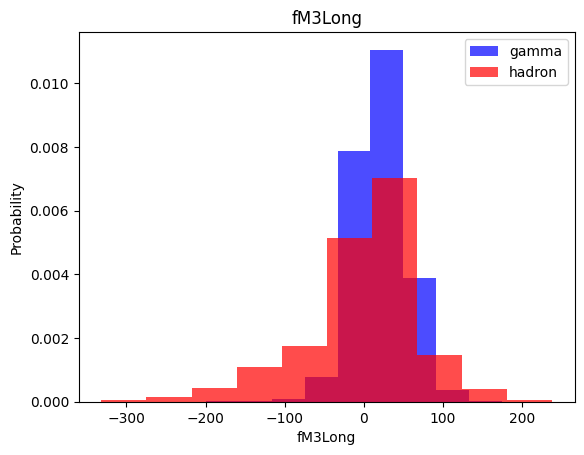

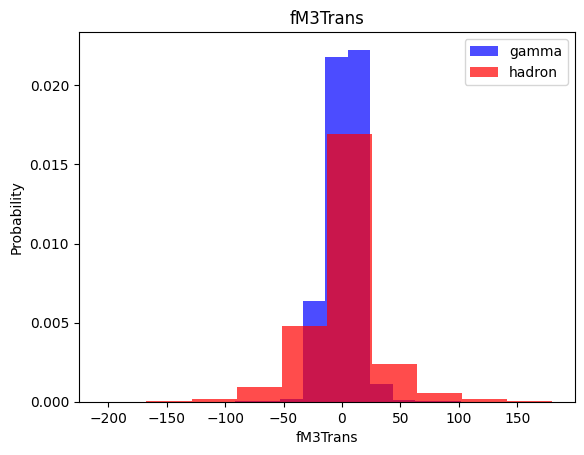

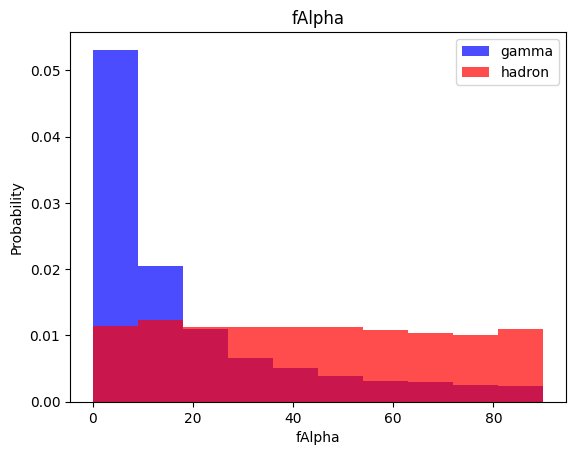

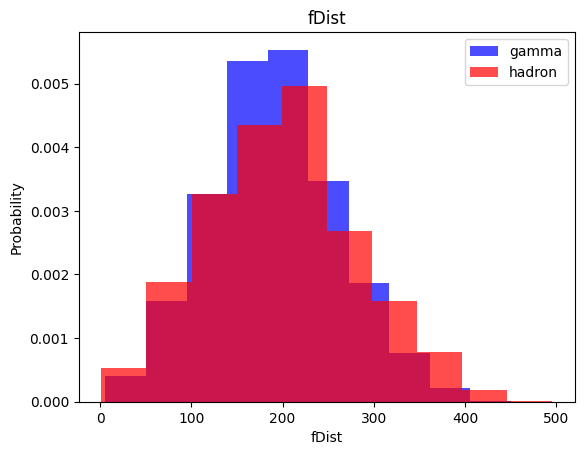

In [4]:
# Define column names
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]

df = pd.read_csv("Dataset/magic04.data", names=cols)

df["class"] = (df["class"] == "g").astype(int)

for label in cols[:-1]:
  plt.hist(df[df["class"]==1][label], color='blue', label='gamma', alpha=0.7, density=True)
  plt.hist(df[df["class"]==0][label], color='red', label='hadron', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

### Split training data

The dataset is randomly shuffled and split into:
1. Training set: 60% of the data.
2. Validation set: 20% of the data.
3. Test set: 20% of the data.

In [6]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Scale dataset

The features are stand using z-score normalization:
$$z = \frac{x - \mu}{\sigma}$$
>where $\mu$ is the mean and $\sigma$ is the standard deviation.

If `oversample=True`, the minority class is oversampled using `RandomOverSampler`.


In [7]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [8]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

#Train

###Train using k nearest neighbors

### K-Nearest Neighbors (KNN)

KNN is a **non-parametric, instance-based classification algorithm**.  
It assigns a class to a test sample based on the classes of its $k$ nearest neighbors in the feature space.

The prediction for a sample $X_{\text{test}}$ is:

$$
\hat{y} = \arg\max_{c \in C} \sum_{i \in \text{NN}(X_{\text{test}})} \mathbf{1}(y_i = c)
$$

- $\text{NN}(X_{\text{test}})$ are the indices of the $k$ nearest neighbors of $X_{\text{test}}$.  
- $\mathbf{1}(y_i = c)$ is 1 if neighbor $i$ belongs to class $c$, otherwise 0.  
- $C$ is the set of all possible classes.

#### Notes:
- Distance metrics commonly used: **Euclidean**, **Manhattan**, or **Minkowski** distance.  
- The choice of $k$ is critical:  
  - Small $k$ → sensitive to noise  
  - Large $k$ → smoother decision boundaries  
- Features should be **standardized** to ensure fair distance calculations.


In [9]:
from sklearn.neighbors import KNeighborsClassifier


The KNN algorithm is used to classify data points based on the majority class of their ( k )-nearest neighbors.
( k = 5 ) is chosen as the number of neighbors.

In [10]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Metrics such as Accuracy, ROC-AUC, Precision, Recall, and F1-score are calculated and stored for each model.  

The ROC-AUC score is computed as:

$$
\text{ROC-AUC} = \int_0^1 \text{TPR(FPR)} \, d(\text{FPR})
$$

>where $\text{TPR}$ is the true positive rate and $\text{FPR}$ is the false positive rate.


In [148]:
results = []
roc_curves = {}
pr_curves = {}
def store_metrics(name, x_test, y_pred):
  report = classification_report(y_test, y_pred, output_dict=True)
  results.append({
      "Model": name,
      "Accuracy": accuracy_score(y_test, y_pred),
      "ROC-AUC": roc_auc_score(y_test, y_scores),
      "Precision (macro)": report["macro avg"]["precision"],
      "Recall (macro)": report["macro avg"]["recall"],
      "F1-score (macro)": report["macro avg"]["f1-score"]
  })


In [90]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
def print_metrics(y_test, y_pred):
  roc_auc = roc_auc_score(y_test, y_pred)
  print("\nROC-AUC Score:", roc_auc)

  accuracy = accuracy_score(y_test, y_pred)
  print("\nAccuracy:", accuracy)

  print("\nClassification report: \n")
  print(classification_report(y_test, y_pred))

In [149]:
y_pred = knn_model.predict(X_test)
y_scores = knn_model.predict_proba(X_test)[:, 1]
store_metrics("KNN", X_test, y_pred)

In [16]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.7856415972087614

Accuracy: 0.8038906414300736
Classification report: 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1340
           1       0.85      0.85      0.85      2464

    accuracy                           0.80      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.80      0.80      0.80      3804



In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import seaborn as sns

# Function 1: Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, class_names):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
  xticklabels=class_names, yticklabels=class_names)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()


# Function 2: ROC Curve with threshold highlights
def plot_roc_curve(y_test, y_scores, key_thresh=[0.01, 0.02, 0.05]):
  roc_auc = roc_auc_score(y_test, y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
  plt.plot([0,1], [0,1], linestyle="--", color="gray")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.grid(True)
  plt.show()


# Function 3: Precision-Recall Curve
def plot_precision_recall(y_test, y_scores):
  precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_scores)
  plt.figure(figsize=(6, 5))
  plt.plot(recalls, precisions, label="Precision-Recall Curve", linewidth=2)
  plt.xlabel("Recall (Sensitivity)")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

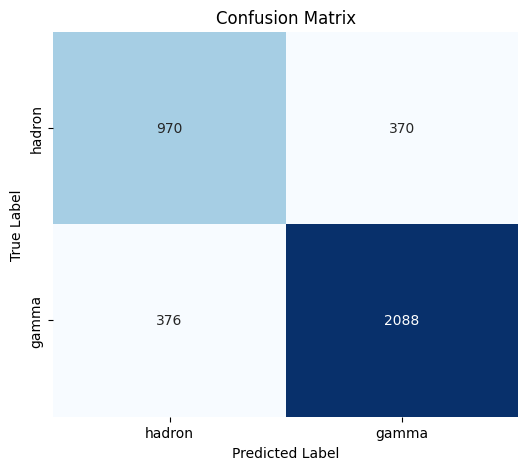

In [21]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

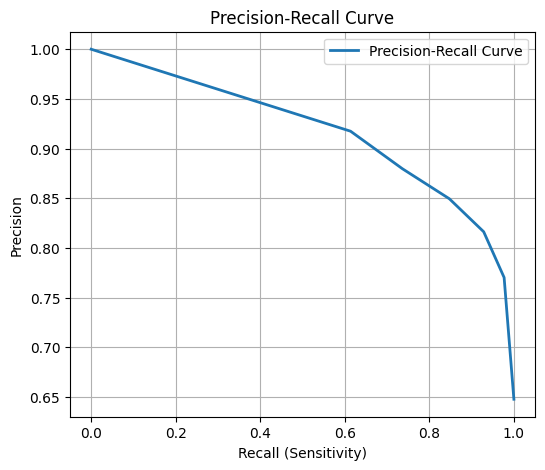

In [55]:
plot_precision_recall(y_test, y_scores)

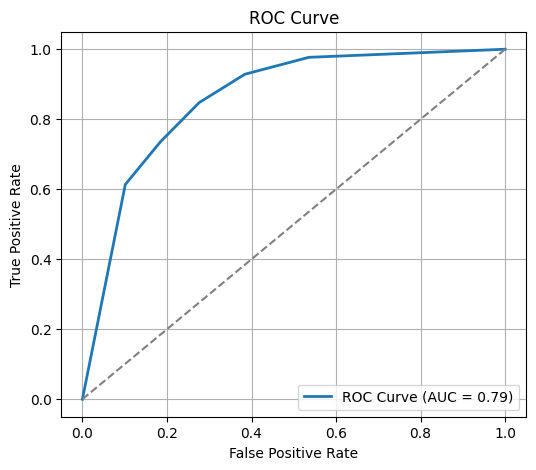

In [56]:
plot_roc_curve(y_test, y_scores)

###Train using Naive Bayes

### Naive Bayes

Naive Bayes is a probabilistic classification algorithm based on **Bayes' theorem**.  
It assumes that features are conditionally independent given the class.

The predicted probability of class $y$ given features $X = [x_1, x_2, ..., x_n]$ is:

$$
P(y \mid X) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)
$$

- $P(y)$ is the prior probability of class $y$.  
- $P(x_i \mid y)$ is the likelihood of feature $x_i$ given class $y$.  

The predicted class is the one with the highest posterior probability:

$$
\hat{y} = \arg\max_{y} P(y \mid X)
$$

#### Notes:
- The **conditional independence assumption** simplifies computation, even if the assumption is not strictly true.  
- Works well for high-dimensional datasets.  
- For continuous features, a **Gaussian Naive Bayes** is often used, assuming $x_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$ for each class.


In [27]:
from sklearn.naive_bayes import GaussianNB

In [28]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [150]:
y_pred = nb_model.predict(X_test)
y_scores = nb_model.predict_proba(X_test)[:, 1]
store_metrics("Naive Bayes", X_test, y_pred)

In [30]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.6554752616786199

Accuracy: 0.7276550998948476

Classification report: 

              precision    recall  f1-score   support

           0       0.69      0.41      0.52      1340
           1       0.74      0.90      0.81      2464

    accuracy                           0.73      3804
   macro avg       0.71      0.66      0.66      3804
weighted avg       0.72      0.73      0.71      3804



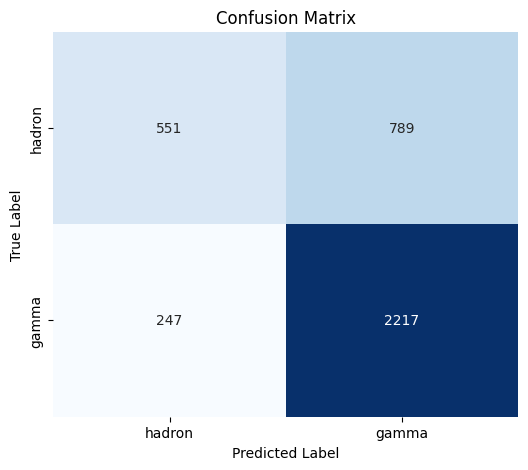

In [31]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

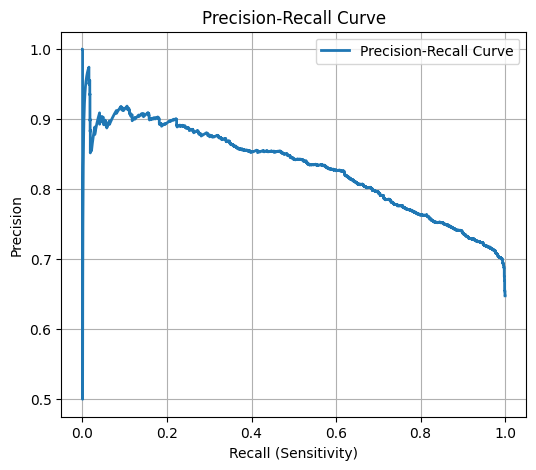

In [58]:
plot_precision_recall(y_test, y_scores)

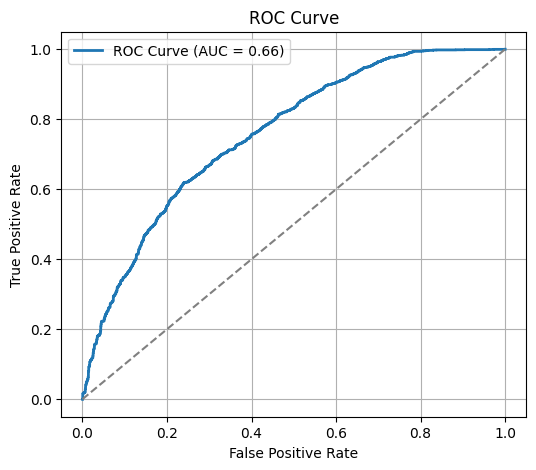

In [59]:
plot_roc_curve(y_test, y_scores)

### Train with logistic Regression

### Logistic Regression

Logistic Regression is a classification algorithm that models the probability of a binary outcome $y \in \{0,1\}$ given input features $X = [x_1, x_2, ..., x_n]$.  

The model estimates the probability using the **sigmoid (logistic) function**:

$$
P(y=1 \mid X) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

where

$$
z = (\beta_0) + \sum_{i=1}^{n} (\beta_i) x_i
$$

- $(\beta_0)$ is the intercept.  
- $(\beta_i)$ are the model coefficients for each feature $x_i$.  

The predicted class is obtained by applying a threshold (usually 0.5):

$$
\hat{y} =
\begin{cases}
1 & \text{if } P(y=1 \mid X) \ge 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

#### Notes:
- Logistic Regression models the **log-odds** (logit) of the outcome as a linear combination of the features:

$$
\text{logit}(P) = \log\frac{P(y=1 \mid X)}{1-P(y=1 \mid X)} = (\beta_0) + \sum_{i=1}^{n} (\beta_i) x_i
$$

- The coefficients $(\beta_i)$ indicate the effect of a one-unit change in the feature $x_i$ on the **log-odds** of the positive class.  
- Features are usually **standardized** (e.g., using z-score normalization) to improve convergence and interpretability.  


In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [151]:
y_pred = lg_model.predict(X_test)
y_scores = lg_model.predict_proba(X_test)[:, 1]
store_metrics("Logistic Regression", X_test, y_pred)

In [37]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.7658466999418492

Accuracy: 0.7802313354363828

Classification report: 

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1340
           1       0.84      0.81      0.83      2464

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.76      3804
weighted avg       0.78      0.78      0.78      3804



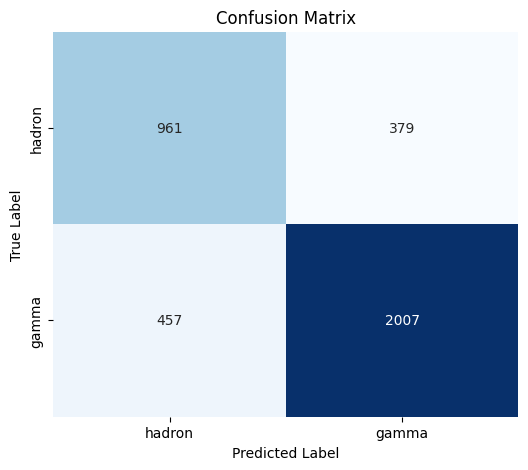

In [39]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

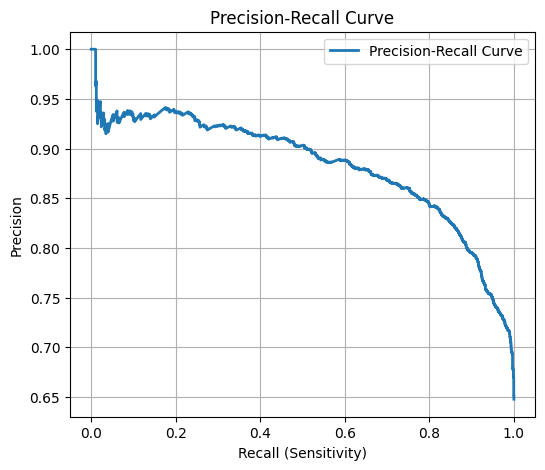

In [61]:
plot_precision_recall(y_test, y_scores)

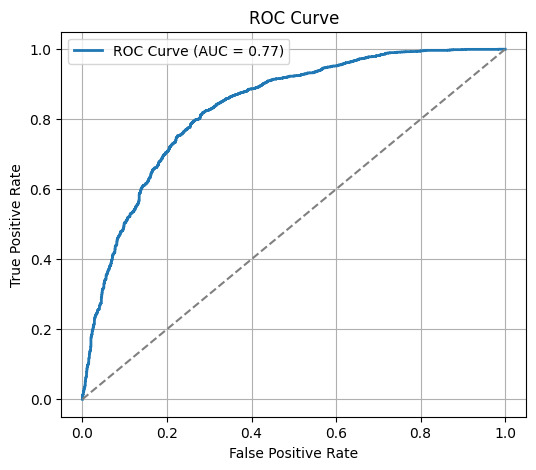

In [62]:
plot_roc_curve(y_test, y_scores)

### Train with SVM

### Support Vector Machine (SVC)

Support Vector Classification (SVC) is a supervised learning algorithm that finds the **optimal hyperplane** separating classes in the feature space.  

For a binary classification problem, the decision function is:

$$
f(X) = \sum_{i=1}^{N} \alpha_i y_i K(X_i, X) + (\beta_0)
$$

- $X_i$ are the support vectors from the training set.  
- $y_i \in \{-1, 1\}$ are the labels of the support vectors.  
- $\alpha_i$ are the Lagrange multipliers learned during training.  
- $K(X_i, X)$ is the kernel function (e.g., **RBF**, **linear**, **polynomial**).  
- $(\beta_0)$ is the bias term.  

The predicted class is determined by the sign of the decision function:

$$
\hat{y} =
\begin{cases}
1 & \text{if } f(X) \ge 0 \\
-1 & \text{otherwise}
\end{cases}
$$

#### Probability Estimates
- When using `SVC(probability=True)`, the algorithm fits a **logistic regression model on the decision function** to produce class probabilities:

$$
P(y=1 \mid X) = \frac{1}{1 + e^{-f(X)}}
$$

- These probabilities are useful for metrics like **ROC-AUC** or **Precision-Recall curves**.

#### Notes:
- Kernel choice affects the decision boundary:  
  - Linear → linearly separable classes  
  - RBF → non-linear boundaries  
- Features should be **standardized**, especially when using distance-based kernels like RBF.  


In [42]:
from sklearn.svm import SVC

In [64]:
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)

In [152]:
y_pred = svm_model.predict(X_test)
y_scores = svm_model.predict_proba(X_test)[:, 1]
store_metrics("SVM", X_test, y_pred)

In [45]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.8400004845900367

Accuracy: 0.852260778128286

Classification report: 

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1340
           1       0.89      0.88      0.89      2464

    accuracy                           0.85      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.85      0.85      0.85      3804



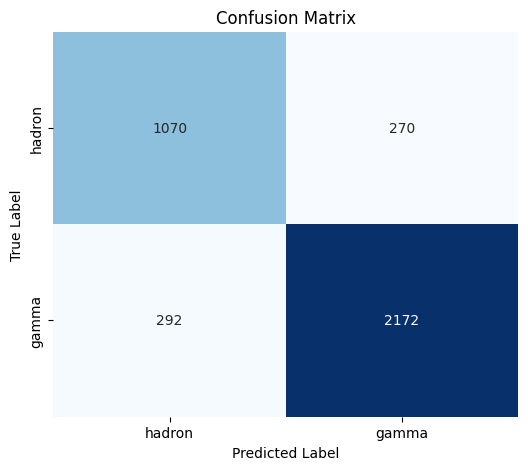

In [46]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

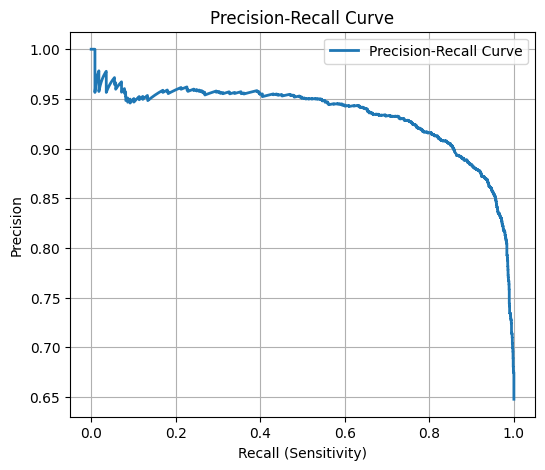

In [66]:
plot_precision_recall(y_test, y_scores)

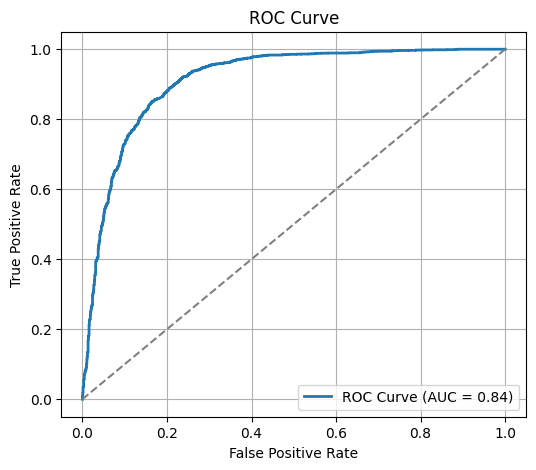

In [67]:
plot_roc_curve(y_test, y_scores)

###Train with Neural Net

A feedforward neural network (multi-layer perceptron, MLP) is a supervised learning algorithm that can model **complex, non-linear relationships** between input features $X = [x_1, x_2, ..., x_n]$ and a binary output $y \in \{0,1\}$.  

#### Architecture
- **Input layer:** Accepts all features of the dataset.  
- **Hidden layer(s):** Fully connected dense layers with $N$ nodes and **ReLU activation**:

$$
h_j = \text{ReLU}\left( \sum_{i=1}^{n} x_i \cdot (\beta_{ij}) + (\beta_{0j}) \right)
$$

  - $(\beta_{ij})$ are the weights connecting input $x_i$ to hidden node $h_j$.  
  - $(\beta_{0j})$ is the bias of hidden node $h_j$.  

- **Dropout layer (optional):** Randomly sets a fraction $p$ of the hidden nodes to zero during training to prevent overfitting.  

- **Output layer:** Single node with **sigmoid activation** for binary classification:

$$
\hat{y} = \sigma \left( \sum_j h_j \cdot (\beta_j) + (\beta_0) \right) = \frac{1}{1 + e^{-z}}
$$

  - Produces the probability of the positive class.  
  - Predicted class:  

$$
\hat{y}_{\text{class}} =
\begin{cases}
1 & \text{if } \hat{y} \ge 0.5 \\
0 & \text{otherwise}
\end{cases}
$$

#### Training Details
- **Loss function:** Binary cross-entropy  

$$
\mathcal{L} = - \frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$

- **Optimizer:** Adam with a learning rate $(lr)$  
- **Batch size:** Number of samples processed before updating the model  
- **Epochs:** Number of passes through the entire training dataset  
- **Early stopping:** Optional, stop training when validation loss stops improving  

#### Notes:
- Hyperparameters like **number of hidden nodes**, **dropout probability**, **learning rate**, and **batch size** are tuned to improve performance.  
- Features are usually **standardized (z-score)** to help the network converge faster.  
- Training history can be visualized with **loss and accuracy curves** to monitor overfitting or underfitting.

In [51]:
import tensorflow as tf

In [49]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [52]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

In [53]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

Output hidden; open in https://colab.research.google.com to view.

In [153]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)
y_scores = least_loss_model.predict(X_test).reshape(-1,)
store_metrics("Neural Network", X_test, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [69]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.8500212008141113

Accuracy: 0.8767087276550999

Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1340
           1       0.88      0.94      0.91      2464

    accuracy                           0.88      3804
   macro avg       0.88      0.85      0.86      3804
weighted avg       0.88      0.88      0.87      3804



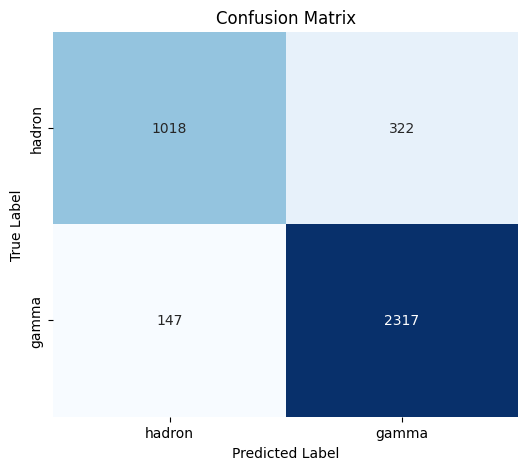

In [70]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

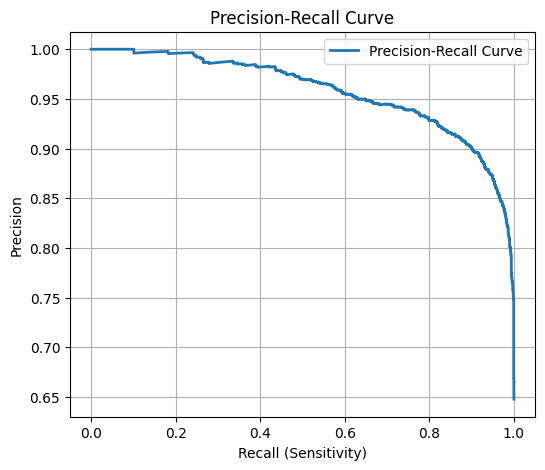

In [71]:
plot_precision_recall(y_test, y_scores)

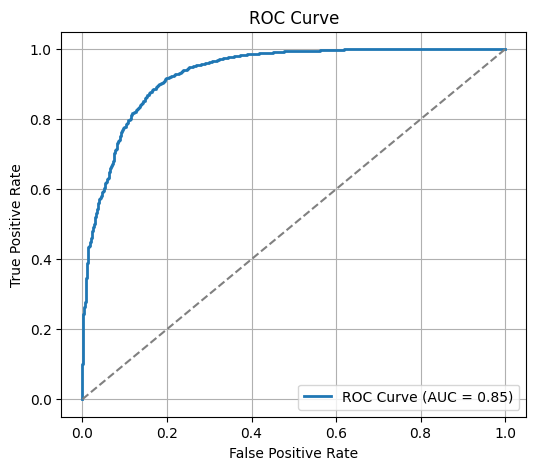

In [72]:
plot_roc_curve(y_test, y_scores)

###Train using Decision Tree

### Decision Tree Classifier

A Decision Tree is a supervised learning algorithm that splits the feature space into regions to predict the class of a sample.  
It recursively partitions the data based on **feature values** to create a tree-like model.

#### Tree Structure
- **Root node:** The first split based on the most informative feature.  
- **Internal nodes:** Represent decisions based on feature thresholds.  
- **Leaf nodes:** Represent predicted class labels.

#### Splitting Criterion
Decision trees use criteria like **Gini impurity** or **Entropy** (Information Gain) to choose the best split.

- **Gini Impurity** for a node:

$$
G = 1 - \sum_{c \in C} (p_c)^2
$$

where $p_c$ is the proportion of samples in class $c$ at that node.

- **Entropy (Information Gain):**

$$
H = - \sum_{c \in C} p_c \log_2(p_c)
$$

Information gain is the reduction in entropy after a split.

#### Prediction
- A sample is passed through the tree from root to leaf, following the decision rules at each node.  
- The **predicted class** is the majority class of the samples in the leaf node:

$$
\hat{y} = \arg\max_{c \in C} \text{count}(c \text{ in leaf})
$$

#### Notes:
- **Max depth** controls tree complexity; deeper trees can overfit.  
- Trees can handle both **categorical and numerical features**.  
- Often used as a **base learner** in ensemble methods like Random Forest or Gradient Boosting.  
- No feature scaling is required.


In [73]:
from sklearn.tree import DecisionTreeClassifier

In [74]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [154]:
y_pred = dt_model.predict(X_test)
y_scores = dt_model.predict_proba(X_test)[:, 1]
store_metrics("Decision Tree", X_test, y_pred)

In [77]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.7770140773405699

Accuracy: 0.7933753943217665

Classification report: 

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1340
           1       0.85      0.83      0.84      2464

    accuracy                           0.79      3804
   macro avg       0.77      0.78      0.78      3804
weighted avg       0.79      0.79      0.79      3804



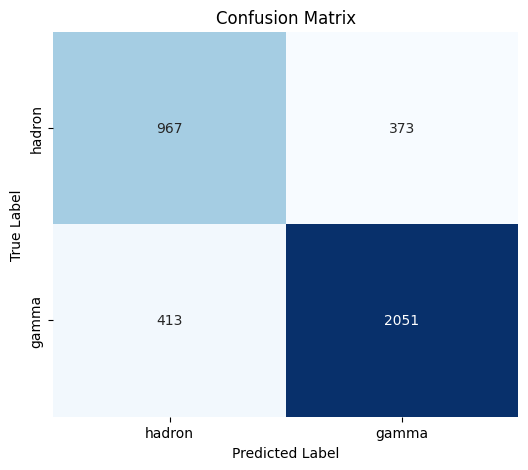

In [78]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

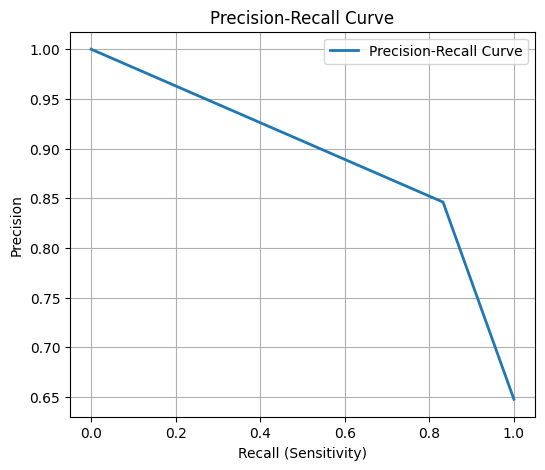

In [81]:
plot_precision_recall(y_test, y_scores)

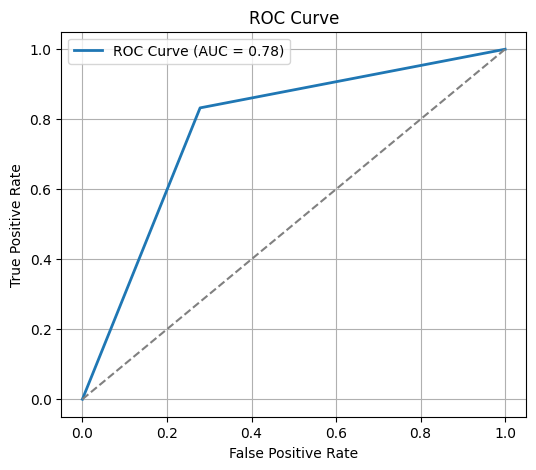

In [82]:
plot_roc_curve(y_test, y_scores)

### Train using Random Forest

### Random Forest Classifier

Random Forest is an **ensemble learning algorithm** that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.

#### Working principle
1. **Bootstrap Aggregation (Bagging):**  
   Each tree is trained on a random subset of the training data (sampled with replacement).  

2. **Random Feature Selection:**  
   At each split in a tree, a random subset of features is considered, introducing additional diversity among trees.

3. **Prediction Aggregation:**  
   - For classification, the final predicted class is obtained by **majority vote** among all trees:

$$
\hat{y} = \text{mode}\left( \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \} \right)
$$

where $\hat{y}_i$ is the prediction of the $i$-th tree and $T$ is the total number of trees.

#### Notes:
- Random Forests are less prone to overfitting than a single decision tree.  
- Hyperparameters to tune include:
  - Number of trees $(n_{\text{estimators}})$  
  - Maximum depth of each tree $(max_{\text{depth}})$
  - Number of features considered at each split $(max_{\text{features}})$  
- Feature scaling is **not required**.  
- Can provide **feature importance** scores for interpretability.


In [83]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [155]:
y_pred = rf_model.predict(X_test)
y_scores = rf_model.predict_proba(X_test)[:, 1]
store_metrics("Random Forest", X_test, y_pred)

In [86]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.8554486092265943

Accuracy: 0.8738170347003155

Classification report: 

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1340
           1       0.89      0.92      0.90      2464

    accuracy                           0.87      3804
   macro avg       0.87      0.86      0.86      3804
weighted avg       0.87      0.87      0.87      3804



In [92]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.8554486092265943

Accuracy: 0.8738170347003155

Classification report: 

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1340
           1       0.89      0.92      0.90      2464

    accuracy                           0.87      3804
   macro avg       0.87      0.86      0.86      3804
weighted avg       0.87      0.87      0.87      3804



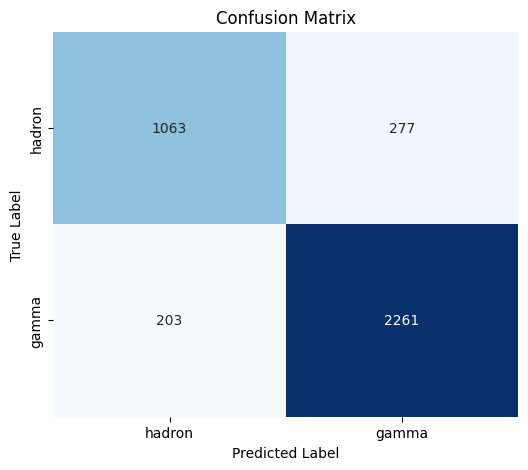

In [93]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

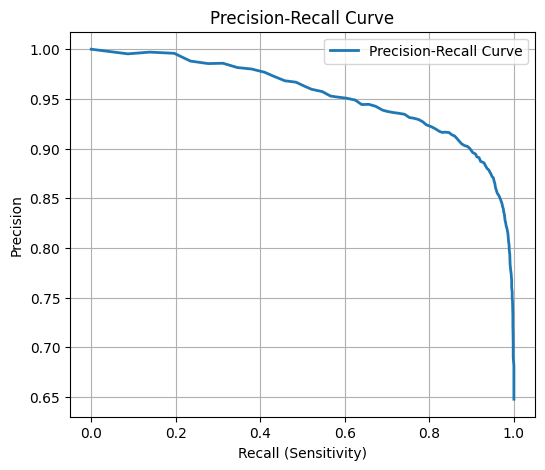

In [94]:
plot_precision_recall(y_test, y_scores)

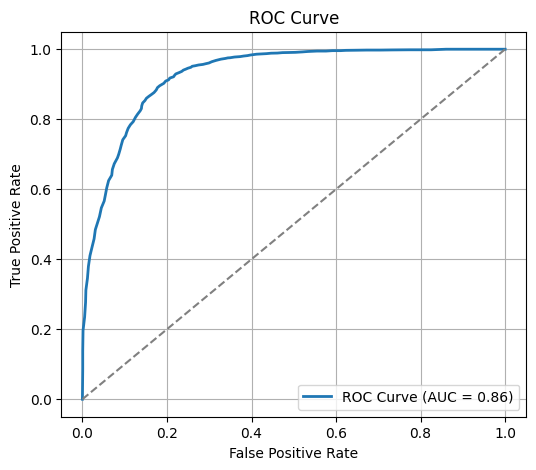

In [95]:
plot_roc_curve(y_test, y_scores)

### Gradient Boosting Result

### Gradient Boosting Classifier

Gradient Boosting is an **ensemble method** that builds a sequence of decision trees, where each tree tries to **correct the errors** of the previous trees.  

It is a **boosting algorithm**, meaning trees are built **sequentially** and combined to improve predictive performance.

#### Working principle
1. Initialize the model with a constant prediction, usually the **mean of the targets** for regression or log-odds for classification:

$$
F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{m} L(y_i, \gamma)
$$

where $L$ is the loss function (e.g., binary cross-entropy) and $m$ is the number of training samples.

2. For each boosting iteration $t = 1, 2, ..., T$:
   - Compute the **residuals (pseudo-residuals)**:

$$
r_{it} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{t-1}(x)}
$$

   - Fit a **decision tree** to the residuals.  
   - Update the model:

$$
F_t(x) = F_{t-1}(x) + \eta \cdot h_t(x)
$$

where $h_t(x)$ is the prediction of the $t$-th tree and $\eta$ is the **learning rate**.

3. Final prediction for classification:

$$
\hat{y} = \sigma(F_T(x)) = \frac{1}{1 + e^{-F_T(x)}}
$$

#### Notes:
- Key hyperparameters:
  - Number of trees $(n_{\text{estimators}})$  
  - Tree depth $(n_{\text{depth}})$
  - Learning rate $(\eta)$  
  - Subsample fraction for stochastic gradient boosting  
- Gradient Boosting often **outperforms Random Forest** on structured/tabular data but is more sensitive to hyperparameter tuning.  
- Features **do not need scaling**, but proper preprocessing can still help.


In [96]:
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [156]:
y_pred = gb_model.predict(X_test)
y_scores = gb_model.predict_proba(X_test)[:, 1]
store_metrics("Gradient Boosting", X_test, y_pred)

In [98]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.8478950620275246

Accuracy: 0.8596214511041009

Classification report: 

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1340
           1       0.89      0.89      0.89      2464

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



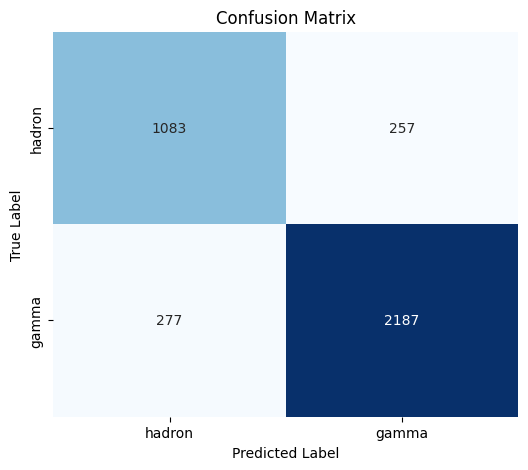

In [99]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

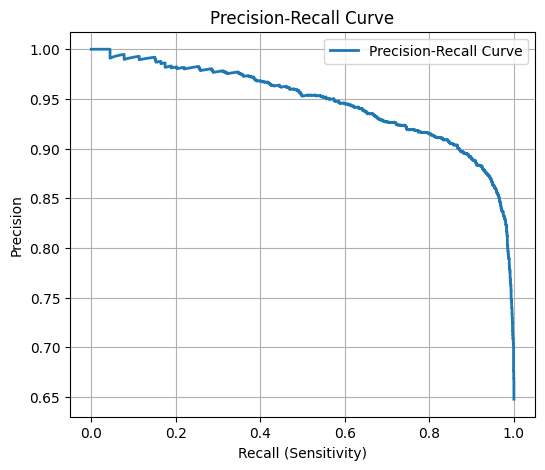

In [100]:
plot_precision_recall(y_test, y_scores)

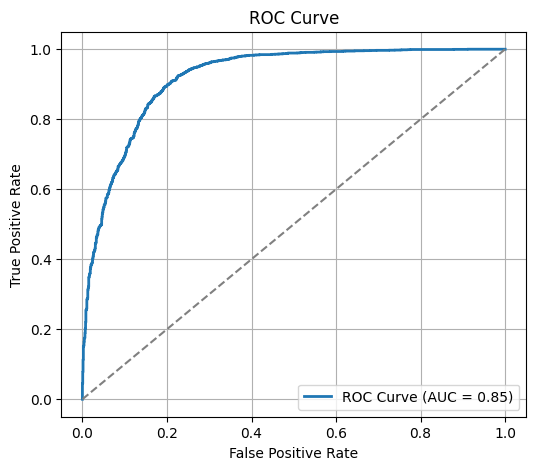

In [102]:
plot_roc_curve(y_test, y_scores)

### Linear Discriminant Analysis

In [103]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [104]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [157]:
y_pred = lda_model.predict(X_test)
y_scores = lda_model.predict_proba(X_test)[:, 1]
store_metrics("Linear Discriminant Analysis", X_test, y_pred)

In [106]:
print_metrics(y_test, y_pred)


ROC-AUC Score: 0.7638756299670479

Accuracy: 0.7862776025236593

Classification report: 

              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1340
           1       0.83      0.84      0.84      2464

    accuracy                           0.79      3804
   macro avg       0.77      0.76      0.76      3804
weighted avg       0.79      0.79      0.79      3804



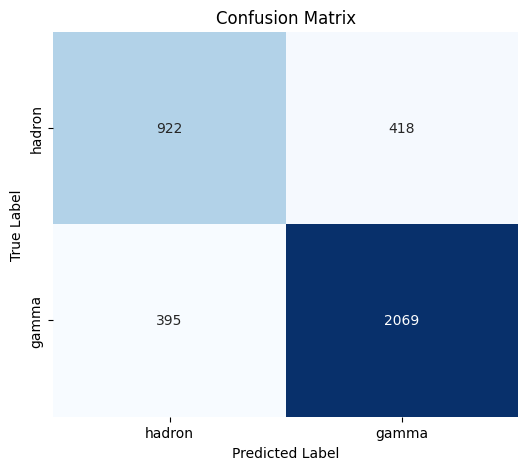

In [107]:
plot_confusion_matrix(y_test, y_pred, class_names=["hadron", "gamma"])

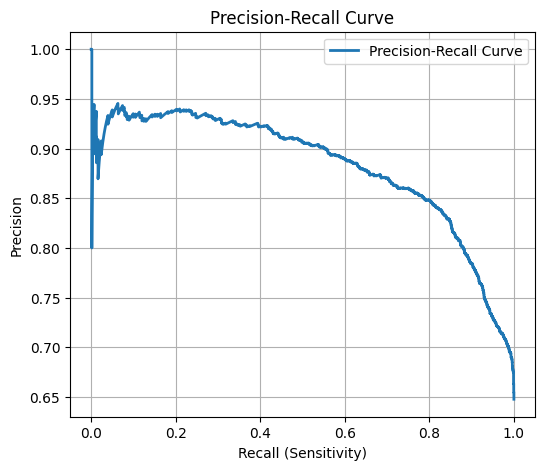

In [108]:
plot_precision_recall(y_test, y_scores)

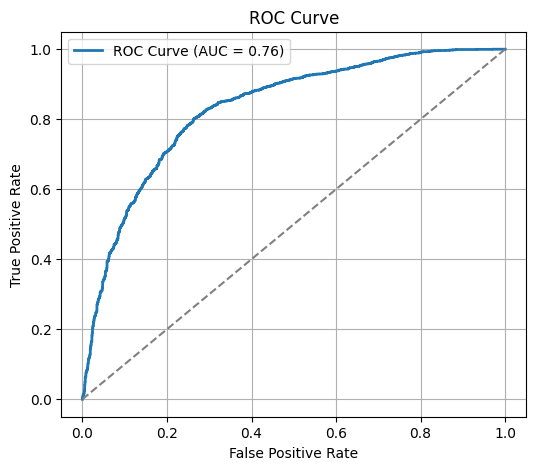

In [110]:
plot_roc_curve(y_test, y_scores)

# Performance of Models

The results of all models are summarized in a table and visualized using bar plots to compare **Accuracy and ROC-AUC** and **Precision, Recall, and F1-Score**.

In [158]:
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,ROC-AUC,Precision (macro),Recall (macro),F1-score (macro)
0,KNN,0.803891,0.858868,0.785062,0.785642,0.785350
1,Naive Bayes,0.727655,0.757619,0.714001,0.655475,0.663019
2,Logistic Regression,0.780231,0.834490,0.759436,0.765847,0.762255
3,SVM,0.852261,0.912144,0.837522,0.840000,0.838726
4,Neural Network,0.876709,0.933529,0.875902,0.850021,0.860434
5,Decision Tree,0.793375,0.777014,0.773423,0.777014,0.775114
6,Random Forest,0.873817,0.928107,0.865256,0.855449,0.859924
7,Gradient Boosting,0.859621,0.919667,0.845584,0.847895,0.846710
8,Linear Discriminant Analysis,0.786278,0.831537,0.766001,0.763876,0.764903


##Accuracy & ROC_AUC

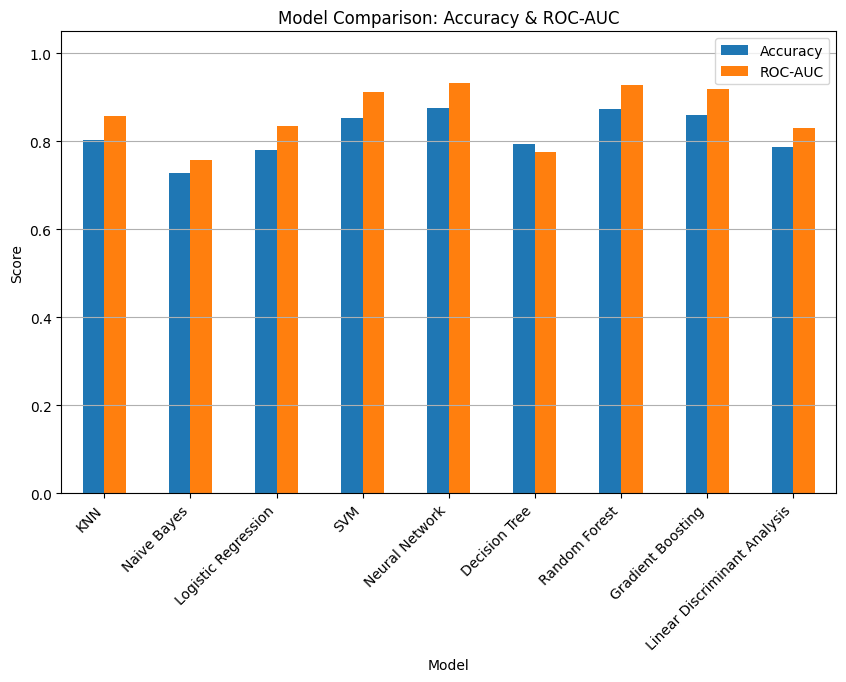

In [161]:
df_results.set_index("Model")[["Accuracy", "ROC-AUC"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Accuracy & ROC-AUC")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()

##Precision, Recall, F1-score

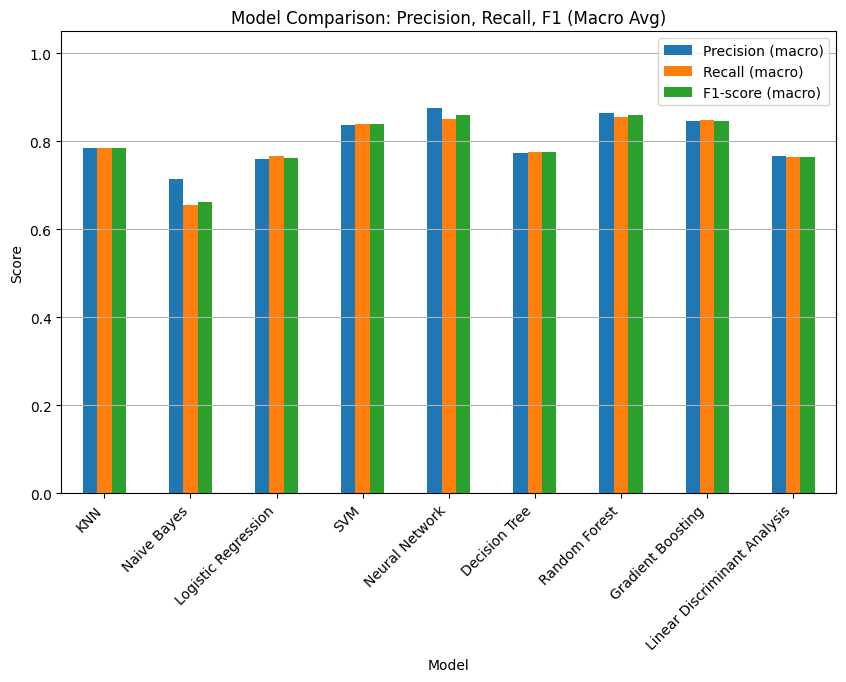

In [162]:
df_results.set_index("Model")[["Precision (macro)", "Recall (macro)", "F1-score (macro)"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison: Precision, Recall, F1 (Macro Avg)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()